In [120]:
# Since the flights data is only updated once a month, here we are trying different ways 
# for filling na's until next month's data is released

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [36]:
# We now read the exogenous data (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [37]:
country = 'Italy'
variable = 'new_cases'
initialdate = '01-01-2020'
enddate = '31-07-2020' 

# We now need to filter the country/dates, and aply 7-day rolling mean:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
#exogenous_ctry = exogenous_ctry.loc[initialdate:]

# We apply the 7-day rolling mean, as in the endogenous data
#exogenous_ctryR = exogenous_ctry.rolling(7).mean()
exogenous_ctry = exogenous_ctry.loc['2020-01-07':]

In [45]:
exogenous_ctry.tail()

,schoolclosing_Italy,workplaceclosing_Italy,cancelpublicevents_Italy,restrictionsongatherings_Italy,closepublictransport_Italy,stayathomerequirements_Italy,domestictravel_Italy,internationaltravel_Italy,publicinfocampaign_Italy,testingpolicy_Italy,contacttracing_Italy,mask_Italy,FlightsArr_Italy,Positive_rate_Italy,dummy_Positive_rate_Italy
2020-08-15,3.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,81.0,889.0,0.019000,0.0
2020-08-16,3.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,81.0,889.0,0.021000,0.0
2020-08-17,3.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,81.0,889.0,0.020000,0.0
2020-08-18,3.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,81.0,889.0,0.019000,0.0
2020-08-19,3.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,81.0,889.0,0.018365,1.0


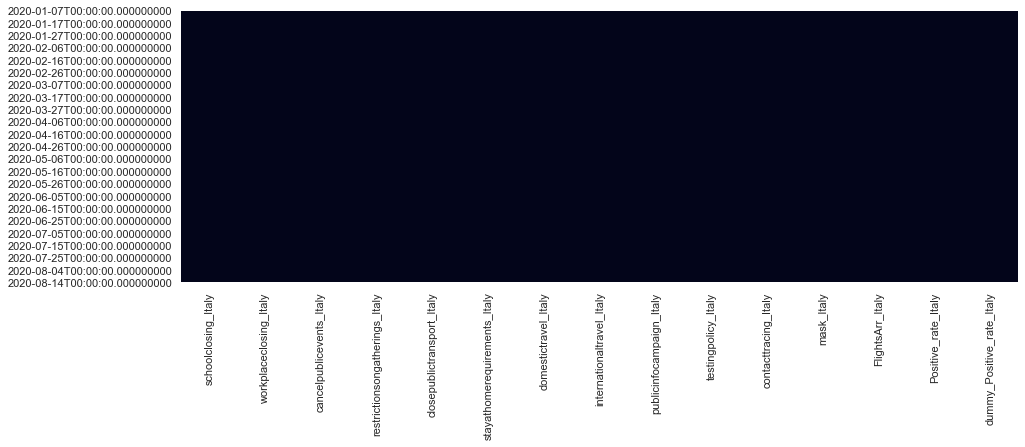

In [42]:
# Interesting plot for looking at nans across a dataset
sns.heatmap(exogenous_ctry.isnull(), cbar=False)

In [46]:
exogenous_ctry_flights = exogenous_ctry.loc[:enddate, exogenous_ctry.columns.str.contains('Flights')]

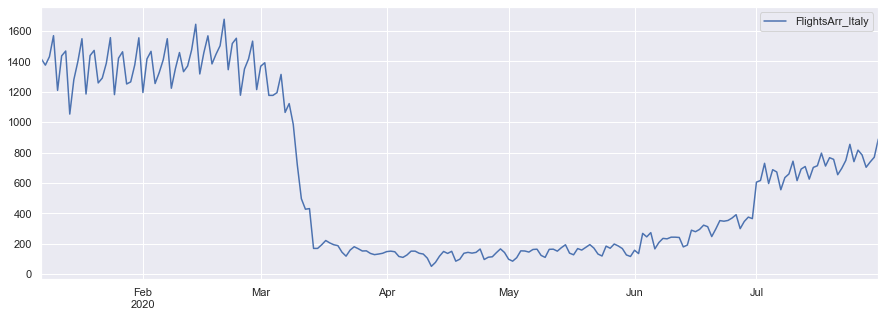

In [47]:
exogenous_ctry_flights.plot()

In [48]:
# Extend indexes at the beginning and end
new_index = pd.date_range('2019-12-01', '2020-08-19', freq='D')
new_index

DatetimeIndex(['2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10',
               ...
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19'],
              dtype='datetime64[ns]', length=263, freq='D')

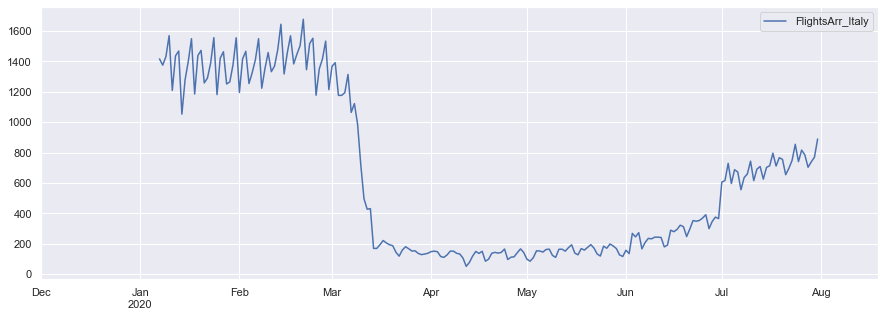

In [52]:
# Reindex data with above new index
exogenous_ctry_flightsI = exogenous_ctry_flights.reindex(new_index)
exogenous_ctry_flightsI.plot()

            FlightsArr_Italy
2020-07-31             889.0
2020-08-01             889.0
2020-08-02             889.0
2020-08-03             889.0
2020-08-04             889.0
2020-08-05             889.0
2020-08-06             889.0
2020-08-07             889.0
2020-08-08             889.0
2020-08-09             889.0
2020-08-10             889.0
2020-08-11             889.0
2020-08-12             889.0
2020-08-13             889.0
2020-08-14             889.0
2020-08-15             889.0
2020-08-16             889.0
2020-08-17             889.0
2020-08-18             889.0
2020-08-19             889.0


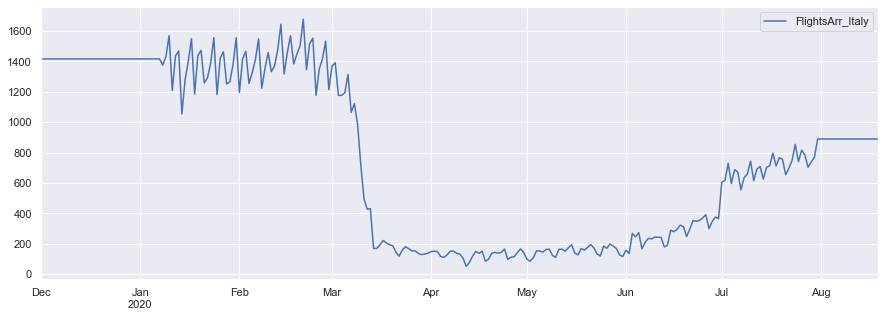

In [53]:
# Use interpolate to fill nas at the beginning and end
method = 'linear'
exogenous_ctry_flightsI.interpolate(method=method, limit_direction='both').plot()
print(exogenous_ctry_flightsI.interpolate(method=method, limit_direction='both').tail(20))

            FlightsArr_Italy
2020-07-29             738.0
2020-07-30             769.0
2020-07-31             889.0
2020-08-01             889.0
2020-08-02             889.0
2020-08-03             889.0
2020-08-04             889.0
2020-08-05             889.0
2020-08-06             889.0
2020-08-07             889.0
2020-08-08             889.0
2020-08-09             889.0
2020-08-10             889.0
2020-08-11             889.0
2020-08-12             889.0
2020-08-13             889.0
2020-08-14             889.0
2020-08-15             889.0
2020-08-16             889.0
2020-08-17             889.0
2020-08-18             889.0
2020-08-19             889.0


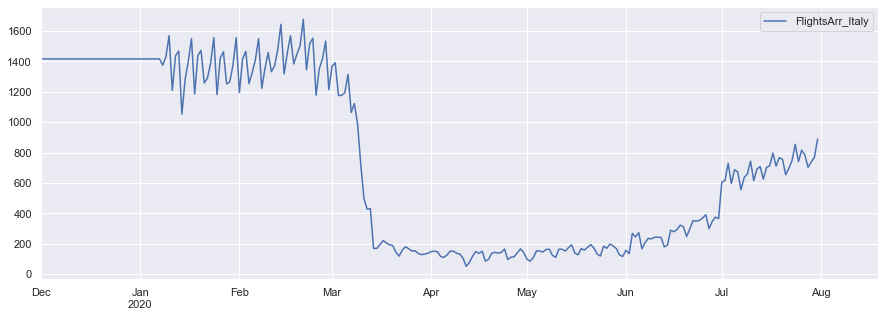

In [92]:
# Use interpolate to fill nas at the beginning and end
method = 'linear'
exogenous_ctry_flightsI.interpolate(method=method, limit_direction='backward').plot()
print(exogenous_ctry_flightsI.interpolate(method=method, limit_direction='both').tail(22))

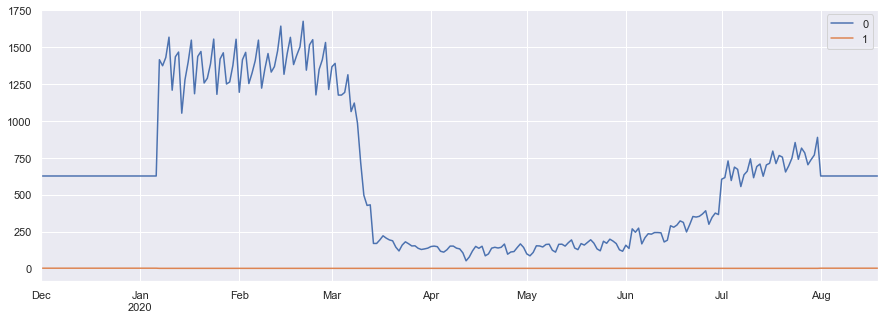

In [66]:
# Tried SimpleImputer, but there are very little strategies options, so doesn't add any value
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp_mean_fpd = pd.DataFrame(imp_mean.fit_transform(exogenous_ctry_flightsI), index=exogenous_ctry_flightsI.index)
imp_mean_fpd.plot()

In [90]:
exogenous_ctry_flightsI.rolling(7).mean()['2020-07-20':'2020-07-31'].iloc[0,-1]

724.0

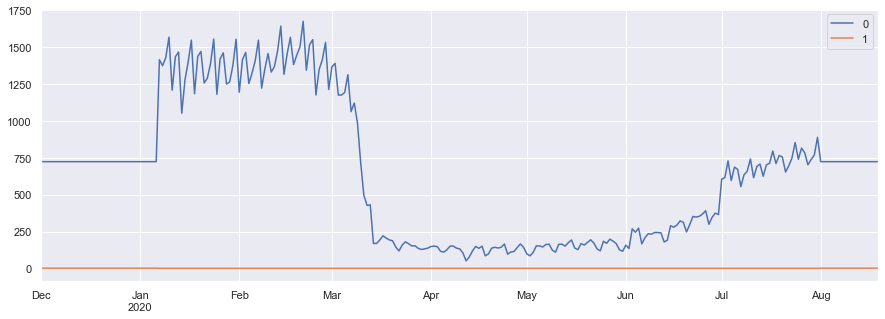

In [91]:
# Tried SimpleImputer, but there are very little strategies options, so doesn't add any value
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=exogenous_ctry_flightsI.rolling(7).mean()['2020-07-20':'2020-07-31'].iloc[0,-1], add_indicator=True)
imp_mean_fpd = pd.DataFrame(imp_mean.fit_transform(exogenous_ctry_flightsI), index=exogenous_ctry_flightsI.index)
imp_mean_fpd.plot()

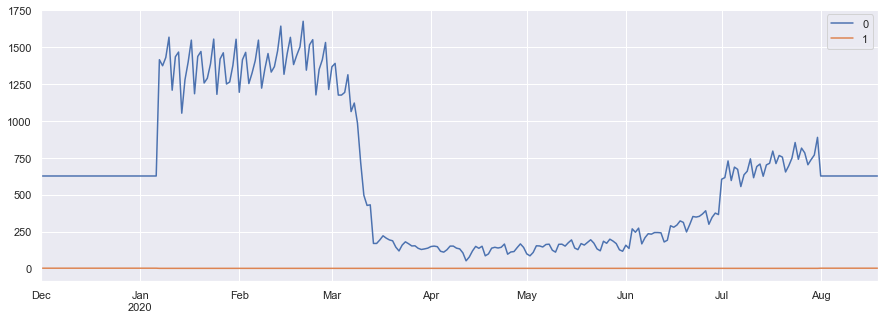

In [58]:
# Looks like not working... might need to update scikit-learn, but don't want to run into environment inconsistencies...
from sklearn.impute import KNNImputer
imp_knn = KNNImputer(n_neighbors=2, weights='distance', add_indicator=True)
imp_knn_fpd = pd.DataFrame(imp_knn.fit_transform(exogenous_ctry_flightsI), index=exogenous_ctry_flightsI.index)
imp_knn_fpd.plot()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1530.696, BIC=1544.007, Time=0.068 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1917.299, BIC=1923.955, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1528.731, BIC=1538.715, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1740.736, BIC=1750.719, Time=0.064 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1919.373, BIC=1922.701, Time=0.004 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1530.683, BIC=1543.995, Time=0.044 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1532.487, BIC=1549.126, Time=0.132 seconds
Total fit time: 0.348 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -761.366
Date:                Tue, 18 Aug 2020   AIC  

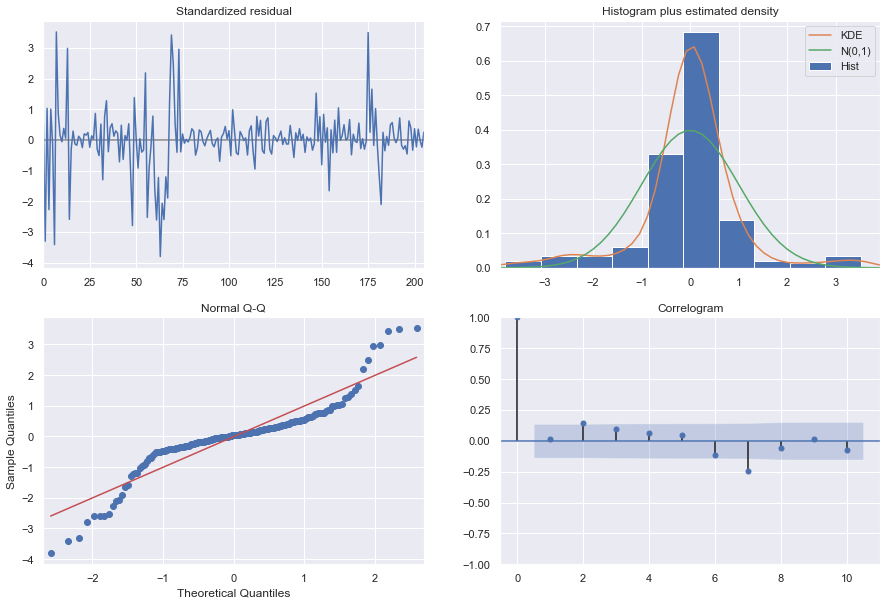

In [88]:
modelauto = pm.auto_arima(exogenous_ctryR_flights.dropna(), start_p=1, start_q=1,
                      test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto.summary())
modelauto.plot_diagnostics(figsize=(15,10))
plt.show()

In [89]:
pred = modelauto.predict(40)

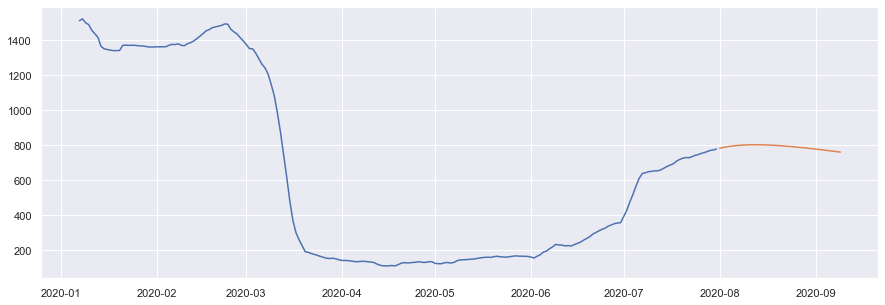

In [90]:
plt.plot(exogenous_ctryR_flights.index, exogenous_ctryR_flights)
plt.plot(pd.DataFrame(pred, index=pd.date_range('2020-08-01', '2020-09-09', freq='D')))
plt.show()

In [122]:
# Tried with different countries and due to the amount of data we have (little), 
# the prediction doesn't add much value... it takes time and a simple interpolate seems like a quick and good solution

In [36]:
import sklearn
sklearn.__version__

'0.22.1'